# Landsat Processing
Created by: Oriana Chegwidden

In [2]:
# %load_ext autoreload
# %autoreload 2
import boto3
from rasterio.session import AWSSession
from s3fs import S3FileSystem
aws_session = AWSSession(boto3.Session(profile_name='default'), 
                         requester_pays=True)
fs = S3FileSystem(profile='default', requester_pays=True)

from osgeo.gdal import VSICurlClearCache
VSICurlClearCache() 
import rasterio as rio
import xarray as xr
import dask
import os
import fsspec
import geopandas as gpd
import regionmask as rm
# from satsearch import Search
from matplotlib.pyplot import imshow
from intake import open_stac_item_collection
import numcodecs
import numpy as np
import rioxarray # for the extension to load
import matplotlib.pyplot as plt
import utm
import pandas as pd
from datetime import datetime
import json
import zarr
import awswrangler as wr

In [3]:
from dask_gateway import Gateway

gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = 2
options.worker_memory = 32
options.environment = {'AWS_REQUEST_PAYER': 'requester'}
cluster = gateway.new_cluster(cluster_options=options)
cluster.adapt(minimum=1, maximum=10)
cluster

KeyboardInterrupt: 

In [159]:
client = cluster.get_client()

Each Landsat scene is stored in cloud optimized geotiff (COG) according to a verbose (but once you understand it, human readable!) naming convention. Landsat Collection 2 uses the same naming convention as Collection 1 which is as follows (lifted from their docs at `https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1656_%20Landsat_Collection1_L1_Product_Definition-v2.pdf`

```LXSS_LLLL_PPPRRR_YYYYMMDD_yyyymmdd_CC_TX```
where
```
L = Landsat  (constant)
X = Sensor  (C = OLI / TIRS, O = OLI-only, T= TIRS-only, E = ETM+, T = TM, M= MSS)
SS = Satellite  (e.g., 04 for Landsat 4, 05 for Landsat 5, 07 for Landsat 7, etc.) 
LLLL = Processing  level  (L1TP, L1GT, L1GS)
PPP  = WRS path
RRR  = WRS row
YYYYMMDD = Acquisition  Year (YYYY) / Month  (MM) / Day  (DD) 
yyyymmdd  = Processing  Year (yyyy) / Month  (mm) / Day (dd)
CC = Collection  number  (e.g., 01, 02, etc.) 
TX= RT for Real-Time, T1 for Tier 1 (highest quality), and T2 for Tier 2

```

Thus, we're looking for scenes coded in the following way:
`LE07_????_PPP_RRR_YYYMMDD_yyyymmdd_02_T1` for Landsat 7 and
`LT05_????_PPP_RRR_YYYMMDD_yyyymmdd_02_T1` for Landsat 5
(but T1 might be wrong there)


We are re-implementing (to the best of our abilities) the methods from Wang et al (in review). Jon Wang's paper said:

```To extend our AGB predictions through space and time, we used time series (1984 – 2014) of 30 m surface reflectance data from the Thematic Mapper onboard Landsat 5 and the Enhanced Thematic Mapper Plus onboard Landsat 7. We used the GLAS-derived estimates of AGB as a response variable and the mean growing season (June, July, August) and non-growing season values for each of Landsat’s six spectral reflectance bands as the predictors in an ensemble machine learning model```

So we'll be looking for:
* Landsat 5 (Thematic mapper) and 7 (Enhanced Thematic Mapper Plus)
* Growing season (June-August) and non-growing season (Sept-May) averages at an annual timestep. <--- will need to figure out around the calendar whether we want consecutive
* All six spectral reflectance bands
* We'll do a quality thresholding of cloudless cover for now based upon their thresholding

In orienting myeslf, these are the potential collection options I've figured out (by poking around here on the [sat-api catalog](https://landsatlook.usgs.gov/sat-api/collections):
* `landsat-c2l2-sr` Landsat Collection 2 Level-2 UTM Surface Reflectance (SR) Product
* `landsat-c2l2alb-sr` Landsat Collection 2 Level-2 Albers Surface Reflectance (SR) Product
* `landsat-c1l2alb-sr` Landsat Collection 1 Level-2 Albers Surface Reflectance (SR) Product <-- we don't want this one (b/c we'll go with collection 2)
* `landsat-c2l1` Landsat Collection 2 Level-1 Product <-- don't think we want this because we want surface reflectance


Run this once to apply the aws session to the rasterio environment

In [3]:
def test_credentials(aws_session, 
                            canary_file='s3://usgs-landsat/collection02/level-2/standard/'+\
                            'tm/2003/044/029/LT05_L2SP_044029_20030827_20200904_02_T1/'+\
                            'LT05_L2SP_044029_20030827_20200904_02_T1_SR_B2.TIF'):    
#     VSICurlClearCache()
    # this file is the canary in the coal mine
    # if you can't open this one you've got *issues* because it exists!
    # also the instantiation of the environment here
    # might help you turn on the switch of the credentials
    # but maybe that's just anecdotal i hate credential stuff SO MUCH
    # if anyone is reading this message i hope you're enjoying my typing
    # as i wait for my cluster to start up.... hmm....

    with rio.Env(aws_session):
        with rio.open(canary_file) as src:
            profile = src.profile
            
            arr = src.read(1)
        

In [4]:
def fix_link(url):
    return url.replace('https://landsatlook.usgs.gov/data', 's3://usgs-landsat')

There are different kinds of QA/QC bands contained in L2SP:
* SR_CLOUD_QA - I think we want this one because anything less than 2 is either just dark dense vegetation or no flags. everything above is stuff like water, snow, cloud (different levels of obscurity). This is the result of the fmask algorithm from Zhu et al.
* QA_PIXEL - this gets a little more specific and goes intot different kinds of clouds. Super interesting but I don't think we want to use it.

Pull in the SR_CLOUD_QA and use as a mask - see Table 5-3 in https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1370_L4-7_C1-SurfaceReflectance-LEDAPS_ProductGuide-v3.pdf for description of cloud integer values to select which ones to use as drop. For now I'll drop anything greater than 1 (0= no QA concerns and 1 is Dark dense vegetation (DDV)).

In [5]:
def cloud_qa(item):
    if type(item)==str:
        qa_path = item
    else:
        qa_path = fix_link(item._stac_obj.assets['SR_CLOUD_QA.TIF']['href'])
    cog_mask = xr.open_rasterio(qa_path).squeeze().drop('band')
    return cog_mask

First we make the query using sat-search to find every file in the STAC catalog that we want. We'll store that list of files. We'll do this first for a single tile (in this first exmaple just covering Washington State) but then we'll loop through in 1-degree by 1-degree tiles. 

In [6]:
with rio.Env(aws_session):
    test_ds = rioxarray.open_rasterio('s3://usgs-landsat/collection02/level-2/standard/'+\
                            'tm/2003/044/029/LT05_L2SP_044029_20030827_20200904_02_T1/'+\
                            'LT05_L2SP_044029_20030827_20200904_02_T1_SR_B4.TIF')

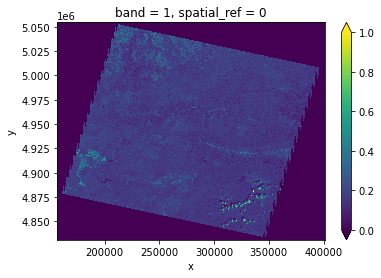

In [7]:
xr.plot.imshow(test_ds.sel(band=1)*0.0000275-.2, vmin=0, vmax=1)

In [12]:
fs.ls('s3://usgs-landsat/collection02/level-2/standard/etm/2021/044/029')

['usgs-landsat/collection02/level-2/standard/etm/2021/044/029/LE07_L2SP_044029_20210108_20210205_02_T2',
 'usgs-landsat/collection02/level-2/standard/etm/2021/044/029/LE07_L2SP_044029_20210124_20210219_02_T1',
 'usgs-landsat/collection02/level-2/standard/etm/2021/044/029/LE07_L2SP_044029_20210209_20210308_02_T1',
 'usgs-landsat/collection02/level-2/standard/etm/2021/044/029/LE07_L2SP_044029_20210225_20210323_02_T1',
 'usgs-landsat/collection02/level-2/standard/etm/2021/044/029/LE07_L2SP_044029_20210313_20210410_02_T1',
 'usgs-landsat/collection02/level-2/standard/etm/2021/044/029/LE07_L2SP_044029_20210329_20210424_02_T1',
 'usgs-landsat/collection02/level-2/standard/etm/2021/044/029/catalog.json']

Due to memory constraints we'll average repeated captures of the same scene. Then we'll average all of those averaged scenes together to create the full mesh. As of now we're just doing a straight average but ideally we would carry the weights of the number of repeats of each scene and do a weighted average when quilting the scenes together.


In [8]:
def grab_ds(item, bands_of_interest, cog_mask, utm_zone):
    if type(item) == str:
        url_list = [item+'_{}.TIF'.format(band) for band in bands_of_interest]
    else:
        url_list = [fix_link(item._stac_obj.assets['{}.TIF'.format(band)]['href']) for band in bands_of_interest]
    da_list = []
    for url in url_list:
        da_list.append(rioxarray.open_rasterio(url, chunks={'x': 1024,
                                                    'y': 1024}))#.load())

    # combine into one dataset
    ds = xr.concat(da_list, dim='band').to_dataset(dim='band').rename({1: 'reflectance'})
    ds = ds.assign_coords({'band': bands_of_interest})
    # fill value is 0; let's switch it to nan
    ds = ds.where(ds != 0)  
    ds = ds.where(cog_mask<2)#.compute()
    ds.attrs["utm_zone"] = utm_zone
#     ds['reflectance'] = ds['reflectance'].astype('int16')
    return ds

In [8]:
def average_stack_of_scenes(ds_list):
    '''
    Average across scenes. This will work the same regardless 
    of whether your scenes are perfectly overlapping or they're offset.
    However, if they're offset it requires a merge and so the entire 
    datacube (pre-collapsing) will be instantiated and might make 
    your kernel explode.
    '''
    utm_zone = []
    for ds in ds_list:
        utm_zone.append(ds.attrs['utm_zone'])
    if len(set(utm_zone))>1:
        print('WATCH OUT: youre averaging scenes from multiple utm projections!!')
        
    full_ds = xr.concat(ds_list, dim='scene').mean(dim='scene')#.compute()
    full_ds.attrs['utm_zone'] = utm_zone[0]
#     full_ds = full_ds.chunk({'band': 1, 'x': 256, 'y': 256})
    return full_ds#.compute()

In [9]:
def write_out(ds, mapper, aws_session):
    encoding = {'reflectance': {'compressor': numcodecs.Blosc()}}
#     with rio.Env(aws_session):
    ds.to_zarr(store=mapper,
                        encoding=encoding, 
                         mode='w')

In [10]:
def access_credentials():
    with open('/home/jovyan/.aws/credentials') as f:
        credentials = f.read().splitlines()
        access_key_id = credentials[1].split('=')[1]
        secret_access_key = credentials[2].split('=')[1]
    return access_key_id, secret_access_key

In [11]:
def get_scene_utm_zone(url):
    metadata_url = url+'_MTL.json'
    json_client = boto3.client('s3')
    data = json_client.get_object(Bucket='usgs-landsat',
                                 Key=metadata_url[18:],
                                 RequestPayer='requester')
    metadata = json.loads(data['Body'].read())
    utm_zone = metadata['LANDSAT_METADATA_FILE']['PROJECTION_ATTRIBUTES']['UTM_ZONE']
    return utm_zone

In [160]:
# @dask.delayed 
def scene_seasonal_average(path, row, year, bucket, access_key_id, secret_access_key,
                           bands_of_interest='all', season='JJA'):
    '''
    Given location/time specifications will grab all valid scenes,
    mask each according to its time-specific cloud QA and then 
    return average across all masked scenes
    '''
    aws_session = AWSSession(boto3.Session(aws_access_key_id=access_key_id,
                                          aws_secret_access_key=secret_access_key),
                            requester_pays=True)#profile_name='default'), requester_pays=True) 
    fs = S3FileSystem(key=access_key_id,
                    secret=secret_access_key, requester_pays=True)

    with dask.config.set(scheduler='single-threaded'): # this? **** #threads #single-threaded # threads??
        with rio.Env(aws_session):
            test_credentials(aws_session)
        #             print('it works!')

            # set where you'll save the final seasonal average
            url = f'{bucket}{path}/{row}/{year}/{season}_reflectance.zarr'
            mapper = fs.get_mapper(url) #used to be fsspec
            # all of this is just to get the right formatting stuff to access the scenes

            landsat_bucket = 's3://usgs-landsat/collection02/level-2/standard/tm/{}/{:03d}/{:03d}/'
            month_keys = {'JJA': ['06', '07', '08']}
            valid_files, ds_list = [], []

            if bands_of_interest=='all':
                bands_of_interest = ['SR_B1', 'SR_B2', 'SR_B3', 
                                         'SR_B4', 'SR_B5', 'SR_B7']
            scene_stores = fs.ls(landsat_bucket.format(year, path, row))
            summer_datestamps = ['{}{}'.format(year, month) for month in month_keys[season]]
            for scene_store in scene_stores:
                for summer_datestamp in summer_datestamps:
                    if summer_datestamp in scene_store:
                        valid_files.append(scene_store)
            for file in valid_files:
                scene_id = file[-40:]
                url = 's3://{}/{}'.format(file, scene_id)
                utm_zone = get_scene_utm_zone(url)
                cloud_mask_url = url+'_SR_CLOUD_QA.TIF'
                cog_mask = cloud_qa(cloud_mask_url)
                ds_list.append(grab_ds(url, bands_of_interest, cog_mask, utm_zone))
            seasonal_average = average_stack_of_scenes(ds_list)
            
            write_out(seasonal_average.chunk({'band': 6, 'x': 1024, 'y': 1024}), mapper, aws_session)
            return url

In [11]:
access_key_id, secret_access_key = access_credentials()

In [18]:
# this is a good test on one cell to see it's working
url='s3://carbonplan-climatetrace/v1/'
ds = scene_seasonal_average(46, 27, 2005, url, access_key_id, secret_access_key)#, aws_session)#.chunk({'band': 6, 'x': 1024, 'y': 1024})

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
{}
<class 'list'>
<class 'str'>


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [26]:
landsat_bucket = 's3://usgs-landsat/collection02/level-2/standard/etm/{}/{:03d}/{:03d}/'

In [27]:
year = 2003
path=178
row=61
fs.ls(landsat_bucket.format(year, row, path))

[]

In [52]:
files=[]
for year in np.arange(2000,2022):
    files+=fs.ls('s3://usgs-landsat/collection02/level-2/standard/etm/{}/178/061'.format(year))

In [24]:
mapper = fs.get_mapper('s3://carbonplan-climatetrace/v1/46/27/2005/JJA_reflectance.zarr')
test_ds = xr.open_zarr(mapper).isel(x=slice(30,50), y=slice(30,50))

In [23]:
test_ds.utm_zone

'10'

In [ ]:
ds.attrs

In [169]:
for task in tasks:
    task.cancel()

Then we take the list of files for a given year to average across growing season for each of the tiles and write it out to a mapper with those specifications.

In [22]:
def add_landsat_utm_zone(scene_gdf):
    '''
    Grab sample file for each landsat scene and
    extract the utm zone then add that to the 
    scene geodataframe
    '''
    scene_gdf['landsat_utm_zone'] = ""
    for scene_id in scene_gdf.index:
        scene_row = washington_scenes.loc[scene_id]['ROW']
        scene_path = washington_scenes.loc[scene_id]['PATH']
        url = 's3://carbonplan-climatetrace/v1/{}/{}/2004/JJA_reflectance.zarr'.format(scene_path, scene_row)
        landsat_utm_zone = xr.open_zarr(fs.get_mapper(url)).utm_zone
        washington_scenes.loc[scene_id, 'landsat_utm_zone'] = int(landsat_utm_zone)
    return scene_gdf

In [33]:
dask.config.set({"array.slicing.split_large_chunks": True})

In [13]:
gdf = gpd.read_file('https://prd-wret.s3-us-west-2.amazonaws.com/assets/'
                   'palladium/production/s3fs-public/atoms/files/'
                   'WRS2_descending_0.zip')

In [19]:
congo = gdf.cx[20:21,-1:-0.9]

In [20]:
congo

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
8616,2.58152,6.43720,2789.0,2789.0,1,0,178,61,D,15685,178061,178061,5,13,"POLYGON ((22.27816 -2.32697, 20.63204 -2.08786..."
21140,2.58143,6.43708,2541.0,2541.0,1,0,179,61,D,40981,179061,179061,12,4,"POLYGON ((21.03965 -0.88038, 20.74905 -2.25170..."


In [14]:
washington_scenes = gdf.cx[-125:-115,45:49]

In [35]:
bucket = 's3://carbonplan-climatetrace/v1/'
# PANGEO_SCRATCH=os.environ['PANGEO_SCRATCH_PREFIX']+'/orianac/'
tasks=[]
rerun=False
if rerun:
    with rio.Env(aws_session): # delete
#         for every year in GLAS record
        for year in np.arange(2003,2009):
            # for every row path in the domain
            for [path, row] in washington_scenes[['PATH', 'ROW']].values:
                for season in ['JJA']:
                        tasks.append(
                            client.compute(
                        scene_seasonal_average(path, row, year, bucket, access_key_id, secret_access_key,
                                                              bands_of_interest='all',
                                                              season=season),
                            retries=4))

In [23]:
washington_scenes = add_landsat_utm_zone(washington_scenes)

In [30]:
for year in np.arange(2003,2009):
    i=0
    # for every row path in the domain
    for [path, row] in washington_row_paths:
        for season in ['JJA']:
            url = f'{bucket}{path}/{row}/{year}/{season}_reflectance.zarr'
            if fs.exists(url):
                print(url)
            break
        break
    break

s3://carbonplan-climatetrace/v1/45/26/2003/JJA_reflectance.zarr


### Now that you've inspected the landsat scenes,make sure you have the correct utm zones for each row/path combo, because sometimes they use one that is not what you would expect. For now we'll just do it once, but should probs check that it doesn't change year-to-year

# TODO:
* ~fix why the attrs aren't working in zarr~
* ~rerun all of the washington state scenes~

THEN
* ~add column for utm in the scene shapefile~
* ~loop through all scenes, grab utm from sample file and fill into df~
* ~then use that column to force the projection~
* rerun the projections and create biomass dataframe

### Now let's link with GLAS. We'll loop through every 10x10 degree GLAS tile and repeat this process

### copy over single biomass tile

In [48]:
copy=False
if copy:
    source_mapper = fsspec.get_mapper('gs://carbonplan-climatetrace/intermediates/biomass/50N_120W.zarr')
    # url = os.environ['PANGEO_SCRATCH_PREFIX']+'/orianac/'
    url = 's3://carbonplan-climatetrace/v1/'
    dest_mapper = fs.get_mapper('carbonplan-climatetrace/v1/biomass/50N_120W.zarr')
    # fsspec.get_mapper(url+'biomass/50N_120W.zarr', storage_options={'profile': 'default'})
    ds = xr.open_zarr(source_mapper)
    ds = ds.drop('allometric_eq')
    with dask.config.set(scheduler='threads'): # this? **** #threads #single-threaded
        ds.to_zarr(dest_mapper, mode='w', consolidated=True)

### Load in the biomass dataset for this one tile

In [24]:
ul_lat, ul_lon = 50, 120
file_mapper = fs.get_mapper('carbonplan-climatetrace/v1/biomass/{}N_{}W.zarr'.format(ul_lat, ul_lon))
# biomass = xr.open_zarr(PANGEO_SCRATCH+'biomass/{}N_{}W.zarr'.format(ul_lat, ul_lon), consolidated=True).load()

biomass = xr.open_zarr(file_mapper, consolidated=True).load().drop('spatial_ref')
biomass_df = biomass.stack(unique_index=("record_index", "shot_number")).to_dataframe().dropna(how='all')

### Convert it to a geodataframe and attach the landsat row/col info to it. This will form the mapping from IceSAT to Landsat.

In [25]:
biomass_gdf = gpd.GeoDataFrame(
    biomass_df, geometry=gpd.points_from_xy(biomass_df.lon, biomass_df.lat)).set_crs("EPSG:4326")
linked_gdf = gpd.sjoin(biomass_gdf, 
                       washington_scenes, #gdf.cx[-125:-115,45:49], # gdf.cx[-ul_lon:-ul_lon+10,ul_lat-10:ul_lat], 
                       how='inner') # 'left' # by selecting inner you're grabbing the intersection (so dropping any shots 
#that don't have scenes or scenes that don't have shots)

### Now you have the row and path for each shot. Let's now get the url to the appropriate COG. For this we'll need the 

In [27]:
def convert_to_utm(df):
    return utm.from_latlon(df['lat'], df['lon'], force_zone_number=df['landsat_utm_zone'])

In [28]:
def add_projection_info(df):
    projection_info = df.apply(convert_to_utm, axis=1).to_list()
    projected_column_names = ['proj_x', 'proj_y', 'utm_zone', 'utm_letter']
    projection_df = pd.DataFrame(projection_info, columns=projected_column_names, index=df.index)
    updated_df = pd.concat([df, projection_df], axis=1)
    return updated_df

In [29]:
def grab_year(df):
    return datetime.fromtimestamp(df['time']).year

In [30]:
def all_linking(df):
    df = add_projection_info(df)
    df['year'] = df.apply(grab_year, axis=1)
    df['url'] = df.apply(build_url, axis=1)
    return df

In [31]:
def build_url(df):
    return 's3://carbonplan-climatetrace/v1/{}/{}/{}/JJA_reflectance.zarr'.format(df['PATH'], 
                                                                                   df['ROW'], 
                                                                                   df['year'])

In [32]:
linked_gdf = all_linking(linked_gdf)

Do all unique row/path/year combos at same time since they'll be grabbing the same file.
Open the file and loop through each x/y location to get reflectance values

In [37]:
unique_urls = linked_gdf['url'].unique()

In [33]:
def create_combined_landsat_biomass_df(landsat_ds, biomass_df, 
                                       biomass_variables=['biomass', 'glas_elev', 'ecoregion']):
    selected_landsat = landsat_ds.sel(x=xr.DataArray(biomass_df['proj_x'].values, dims='shot'), 
                      y=xr.DataArray(biomass_df['proj_y'].values, dims='shot'),
                      method='nearest').to_dataframe().drop(['x', 'y'], axis=1)
    selected_landsat.index = biomass_df.index
    out_df = pd.concat([biomass_df[biomass_variables], selected_landsat], axis=1)
    return out_df

In [148]:
washington_row_path_strings = ['{}/{}'.format(row, path) for (row, path) in washington_row_paths]

In [38]:
unique_urls

array(['s3://carbonplan-climatetrace/v1/41/26/2003/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/26/2004/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/26/2005/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/26/2006/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/26/2007/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/26/2008/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/27/2003/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/27/2004/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/27/2005/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/27/2006/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/27/2007/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/27/2008/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v1/41/28/2003/JJA_reflectance.zarr',
       's3://carbonplan-climatetrace/v

In [66]:
wr.s3.to_parquet(
    df=washington_df, index=True,
    path='s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet', 
    boto3_session=boto3.Session(aws_access_key_id=access_key_id,
                                          aws_secret_access_key=secret_access_key)
)

{'paths': ['s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet'],
 'partitions_values': {}}

In [67]:
washington_dfs = []
# group the biomass shots according to the scene they overlap
groupby = linked_gdf.groupby('url')
for year in np.arange(2003,2009):
    for (i, (path, row)) in washington_scenes[['PATH', 'ROW']].iterrows():
        for season in ['JJA']:
            url = f'{bucket}{path}/{row}/{year}/{season}_reflectance.zarr'
            try:
                shots_one_scene = groupby.get_group(url)
                ds = xr.open_zarr(fs.get_mapper(url)).drop('spatial_ref').reflectance.to_dataset(dim='band')
                washington_dfs.append(create_combined_landsat_biomass_df(ds, shots_one_scene))
            except:
                print('{} had no shots'.format(url))
washington_df = pd.concat(washington_dfs)
wr.s3.to_parquet(
    df=washington_df, index=True,
    path='s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet', 
    boto3_session=boto3.Session(aws_access_key_id=access_key_id,
                                          aws_secret_access_key=secret_access_key)
)

s3://carbonplan-climatetrace/v1/45/29/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/27/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/28/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/48/29/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/27/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/28/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/46/29/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/49/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/49/27/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/47/26/2003/JJA_reflectance.zarr had no shots
s3://carbonplan-climatetrace/v1/47/27/2003/JJA_reflectance.zarr had no shots

{'paths': ['s3://carbonplan-climatetrace/v1/washington_biomass_landsat.parquet'],
 'partitions_values': {}}

<AxesSubplot:xlabel='record_index,shot_number'>

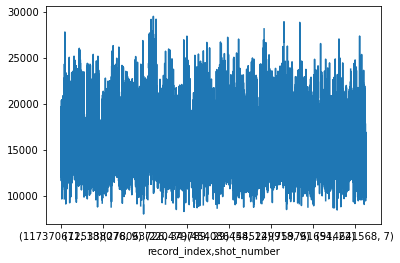

In [76]:
washington_df['SR_B4'].plot()

In [175]:
with rio.Env(aws_session):
    test_ds = rioxarray.open_rasterio('s3://usgs-landsat/collection02/level-2/standard/'+\
                            'tm/2003/045/028/LT05_L2SP_045028_20030106_20200905_02_T1/'+\
                            'LT05_L2SP_045028_20030106_20200905_02_T1_SR_B2.TIF')

In [192]:
test_ds.isel(band=0).x.values

array([548700., 548730., 548760., ..., 785940., 785970., 786000.])

In [174]:
landsat_bucket = 's3://usgs-landsat/collection02/level-2/standard/tm/{}/{:03d}/{:03d}/'
fs.ls(landsat_bucket.format(2003, 45, 28))

['usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030106_20200905_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030122_20200905_02_T2',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030207_20200905_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030223_20200904_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030311_20200904_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030327_20200905_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030412_20200905_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030428_20200905_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT05_L2SP_045028_20030514_20200905_02_T1',
 'usgs-landsat/collection02/level-2/standard/tm/2003/045/028/LT0

In [ ]:
s3 = boto3.client('s3')
object = s3.get_object(Bucket='mytestbucket',Key='EmpId007')
serializedObject = object['Body'].read()

myData = json.loads(serializedObject)

In [198]:
sample_url = 's3://usgs-landsat/collection02/level-2/standard/tm/2003/045/028/'\
    'LT05_L2SP_045028_20030106_20200905_02_T1/LT05_L2SP_045028_20030106_20200905_02_T1_MTL.json'
fs.from_json(sample_url)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [193]:
sample_url = 's3://usgs-landsat/collection02/level-2/standard/tm/2003/045/028/'\
    'LT05_L2SP_045028_20030106_20200905_02_T1/LT05_L2SP_045028_20030106_20200905_02_T1_MTL.txt'

with fs.from_json(sample_url, 'rb') as f:
    print(f.read())

TypeError: from_json() takes 1 positional argument but 2 were given

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


<AxesSubplot:>

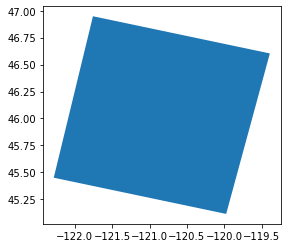

In [162]:
gdf[gdf['PATH']==45][gdf['ROW']==28].plot()

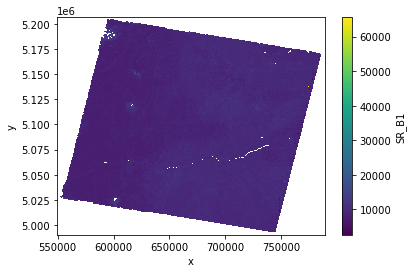

In [158]:
ds.SR_B1.plot()

In [81]:
sample_url = 's3://carbonplan-climatetrace/v1/44/29/2003/JJA_reflectance.zarr'
ds = xr.open_zarr(fs.get_mapper(sample_url)).drop('spatial_ref').reflectance.to_dataset(dim='band')
ds = ds.
# ds['SR_B3'].plot()

In [ ]:
dfasdf

In [105]:
selected_landsat = ds.sel(x=xr.DataArray(shots_one_scene['proj_x'].values, dims='shot'), 
      y=xr.DataArray(shots_one_scene['proj_y'].values, dims='shot'),
      method='nearest').to_dataframe().drop(['x', 'y'], axis=1)
selected_landsat.index = shots_one_scene.index

In [108]:
pd.concat([shots_one_scene, selected_landsat], axis=1)

MeanH      QMCH      VH     biomass  burned  \
record_index shot_number                                                   
122322521    40           8.176169  8.176155  19.682    0.000000     0.0   
122322526    3            1.831306  1.831305   6.880    0.000000     0.0   
             7            5.756794  5.756781  18.854    0.000000     0.0   
             17           3.429633  3.429627  13.468    0.000000     0.0   
             18           4.677802  4.677794  14.592    0.000000     0.0   
...                            ...       ...     ...         ...     ...   
138509436    8            4.292060  4.292054  14.435    0.000000     1.0   
             9            2.553164  2.553160  14.663    0.000000     1.0   
             10           9.412661  9.412633  21.050    0.000000     1.0   
             11           5.770540  5.770529  14.318    0.000000     1.0   
             12           8.869856  8.869826  31.403  171.323542     1.0   

                          ecoregion  eosd   f_slope  glas_elev  h25_Neigh  \
record_index shot_number                                                    
122322521    40               348.0   NaN  1.028316   1566.696   4.737095   
122322526    3                348.0   NaN  0.792156   1583.293  -1.056887   
             7                348.0   NaN  0.692944   1528.847   0.356415   
             17               348.0   NaN  0.688523   1472.855  -1.398679   
             18               348.0   NaN  0.778390   1475.755  -0.949066   
...                             ...   ...       ...        ...        ...   
138509436    8                348.0   NaN  0.603412   1430.443   1.852283   
             9                348.0   NaN  0.716174   1413.006  -0.842717   
             10               348.0   NaN  0.836513   1403.968   2.434095   
             11               348.0   NaN  0.681143   1334.589   0.802963   
             12               348.0   NaN  0.701981   1318.545   0.486897   

                          ...  utm_zone  utm_letter  year  \
record_index shot_number  ...                               
122322521    40           ...        11           T  2003   
122322526    3            ...        11           T  2003   
             7            ...        11           T  2003   
             17           ...        11           T  2003   
             18           ...        11           T  2003   
...                       ...       ...         ...   ...   
138509436    8            ...        11           T  2003   
             9            ...        11           T  2003   
             10           ...        11           T  2003   
             11           ...        11           T  2003   
             12           ...        11           T  2003   

                                                                        url  \
record_index shot_number                                                      
122322521    40           s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
122322526    3            s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
             7            s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
             17           s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
             18           s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
...                                                                     ...   
138509436    8            s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
             9            s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
             10           s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
             11           s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   
             12           s3://carbonplan-climatetrace/v1/44/29/2003/JJA...   

                                SR_B1         SR_B2         SR_B3  \
record_index shot_number                                            
122322521    40           9551.800000  10304.600000  10915.600000   
122322526

In [91]:
selected_landsat

,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B7
shot,,,,,,
0,9551.800000,10304.600000,10915.600000,13380.600000,15999.000000,14202.400000
1,9507.000000,10332.200000,10892.000000,13379.000000,15908.800000,14173.400000
2,9271.333333,9950.833333,10362.666667,13094.333333,15044.500000,13312.666667
3,9650.666667,10402.833333,11020.000000,13184.666667,15216.666667,13974.166667
4,9706.333333,10488.833333,11130.333333,13338.000000,15218.166667,13938.833333
...,...,...,...,...,...,...
896,9749.800000,10895.600000,11928.200000,14246.800000,16215.200000,14651.600000
897,9618.800000,10678.600000,11425.600000,14047.400000,17038.600000,15012.000000
898,9476.000000,10405.200000,10811.600000,13244.800000,14961.000000,13372.400000


In [ ]:
# ideally i could just select out all of the 

In [76]:
ds.sel_points(x=, y=4856174.32039988, method='nearest').to_dataframe()['reflectance']

band
SR_B1     9551.8
SR_B2    10304.6
SR_B3    10915.6
SR_B4    13380.6
SR_B5    15999.0
SR_B7    14202.4
Name: reflectance, dtype: float64

In [389]:
test_strings = []
for string in unique_urls:
    if '44/29' in string:
        test_strings.append(string)

In [390]:
for url in test_strings:
    try:
        ds = xr.open_zarr(fs.get_mapper(url))
        print(url)
        break
    except:
        print('nope')

s3://carbonplan-climatetrace/v1/44/29/2003/JJA_reflectance.zarr


/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1299: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


<AxesSubplot:>

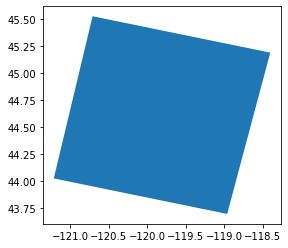

In [393]:
gdf[gdf['PATH']==44][gdf['ROW']==29].plot()

# the landsat datasets aren't lat lon- they're spatial- so we need to index in and find the closest landsat pixel (or pixels?) to the lat/lon

Landsat is in meters with the utm projection of that path/row (need to check for weirdness at utm boundaries).
So, if we give it meters locations we can get back the values from dataset.

In [84]:
x=376435
y=5409203
ds.sel(x=x, y=y, method='nearest').reflectance.values

array([ 8216.33333333,  8869.33333333,  8687.        , 16541.33333333,
       12305.66666667,  9986.66666667])

What we need to do now is make a column of projected x/y in the dataframe